# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [ ]:
# Importing libraries to read the data and transform the data

import numpy as np
import os
from skimage.io import imread
from skimage.transform import resize
from matplotlib import pyplot as plt
import datetime
import os

from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


We set the random seed so that the results don't vary drastically.

In [ ]:
# Seed value setting
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [ ]:
# Reading the train and validation dataset
train_doc = np.random.permutation(open('/content/gdrive/MyDrive/Gesture_Recognition/train.csv').readlines())
val_doc = np.random.permutation(open('/content/gdrive/MyDrive/Gesture_Recognition/val.csv').readlines())

# Initiating the batch size
batch_size = 50

# Sequence index intialization
seq_idx = range(6, 28, 2)

# Image resize dimension initialisation
x_dim, y_dim = 120, 120

In [ ]:
# Class distribution - Train dataset
from collections import Counter
train_class_counter = []
for i in train_doc:
    train_class_counter.append(i[-2:-1])
tc_count = Counter(train_class_counter)

for i in tc_count:
    print('Class {0}: {1}'.format(i, tc_count[i]))

Class 1: 137
Class 3: 137
Class 0: 136
Class 4: 123
Class 2: 130


In [ ]:
# Class distribution - Validation dataset
val_class_counter = []
for i in val_doc:
    val_class_counter.append(i[-2:-1])
vc_count = Counter(val_class_counter)

for i in vc_count:
    print('Class {0}: {1}'.format(i, vc_count[i]))

Class 3: 21
Class 4: 16
Class 2: 22
Class 0: 18
Class 1: 23


## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [ ]:
# Generator function defenition

def generator(source_path, folder_list, batch_size, sequence):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = seq_idx
    x = len(img_idx)
    y, z = x_dim, y_dim
    while True:
        t = np.random.permutation(folder_list)
        num_batches = sequence // batch_size
        for batch in range(num_batches): # iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path +'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    rs_image = resize(image, output_shape=(y, z))

                    batch_data[folder,idx,:,:,0] = rs_image[:,:,0]/rs_image[:,:,0].mean()
                    batch_data[folder,idx,:,:,1] = rs_image[:,:,1]/rs_image[:,:,1].mean()
                    batch_data[folder,idx,:,:,2] = rs_image[:,:,2]/rs_image[:,:,2].mean()

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels
        # Logic for the remainder batch
        if sequence % batch_size > 0:
            new_batch_size = sequence % batch_size
            new_batch = (sequence//batch_size)*batch_size
            batch_data = np.zeros((new_batch_size, x, y, z, 3))
            batch_labels = np.zeros((new_batch_size, 5))
            for folder in range(new_batch_size):
                imgs = os.listdir(source_path + '/' + t[folder + new_batch].split(';')[0])
                for idx, item in enumerate(img_idx):
                    image = imread(source_path + '/' + t[folder + new_batch].split(';')[0] + '/' + imgs[item]).astype(np.float32)
                    rs_image = resize(image, output_shape=(y, z))
                    batch_data[folder,idx,:,:,0] = rs_image[:,:,0]/rs_image[:,:,0].mean()
                    batch_data[folder,idx,:,:,1] = rs_image[:,:,1]/rs_image[:,:,1].mean()
                    batch_data[folder,idx,:,:,2] = rs_image[:,:,2]/rs_image[:,:,2].mean()
                batch_labels[folder, int(t[folder + new_batch].strip().split(';')[2])] = 1
            yield batch_data, batch_labels


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [ ]:
# Sequence number intialisation
train_path = '/content/gdrive/MyDrive/Gesture_Recognition/train'
val_path = '/content/gdrive/MyDrive/Gesture_Recognition/val'
num_train_sequences = len(train_doc)
print('Training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('Validation sequences =', num_val_sequences)

# Epoch intialisation
num_epochs = 100

Training sequences = 663
Validation sequences = 100


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [ ]:
# importing modules required to build NN model

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers import LSTM, ConvLSTM2D, Conv2D, Conv3D, MaxPooling2D, MaxPooling3D, GlobalAveragePooling2D, GlobalAveragePooling3D, Dropout
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers

input_shape = (len(seq_idx), x_dim, y_dim, 3)

In [ ]:
# Model name function definition to set the model name

def set_model_name():
    curr_dt_time = datetime.datetime.now()
    print ('Epochs =', num_epochs)
    # model_dir = '/content/gdrive/MyDrive/Gesture_Recognition/model/'
    model_name = 'model' + '_' + str(curr_dt_time).replace('-', '').replace(' ', '_').replace(':', '_')[:-7] + '/'
    # if not os.path.exists(model_dir+model_name):
        # os.mkdir(model_dir+model_name)
    if not os.path.exists(model_name):
        os.mkdir(model_name)
    # filepath = model_dir + model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
    return (filepath, model_name)

In [ ]:
# Function definition to plot the model accuray and loss

def plot_performance(history):
    plt.figure(figsize=(20,6))
    ax1 = plt.subplot(121)
    ax1 = plt.plot(history.history['loss'])
    ax1 = plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    print('Minimum validation loss: {0} at EPOCH: {1}'.format(np.min(history.history['val_loss']).round(3), np.argmin(history.history['val_loss'])+1))
    plt.axvline(np.argmin(history.history['val_loss']), color='r', linestyle='--')
    plt.axhline(np.min(history.history['val_loss']), color='r', linestyle='--')
    plt.legend(['train', 'validation'], loc='lower left')
    ax2 = plt.subplot(122)
    ax2 = plt.plot(history.history['categorical_accuracy'])
    ax2 = plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('categorical_accuracy')
    plt.xlabel('epoch')
    print('Maximum validation accuracy: {0} at EPOCH: {1}'.format(np.max(history.history['val_categorical_accuracy']).round(3), np.argmax(history.history['val_categorical_accuracy'])+1))
    plt.axvline(np.argmax(history.history['val_categorical_accuracy']), color='r', linestyle='--')
    plt.axhline(np.max(history.history['val_categorical_accuracy']), color='r', linestyle='--')
    plt.legend(['train', 'validation'], loc='lower left')
    plt.show()

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [ ]:
# Generator initialisation
train_generator = generator(train_path, train_doc, batch_size, num_train_sequences)
val_generator = generator(val_path, val_doc, batch_size, num_val_sequences)

In [ ]:
# Extracting the model name
filepath, zip_folder = set_model_name()

# Checkpoint definition for the NN model
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, varbose=1, min_lr=0.01)
callbacks_list = [checkpoint, LR]

Epochs = 100


The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [ ]:
# Steps calculation

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

## Model Building

### Model 1:

*Plain Conv3D model*

In [ ]:
model1 = Sequential()

model1.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model1.add(MaxPooling3D(pool_size=2))

model1.add(Conv3D(64, kernel_size=3, activation='relu'))
model1.add(MaxPooling3D(pool_size=2))

model1.add(Flatten())
model1.add(Dense(512, activation='relu'))

model1.add(Dense(5, activation='softmax'))

optimiser1 = tf.keras.optimizers.SGD()
model1.compile(optimizer=optimiser1, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model1.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_2 (Conv3D)           (None, 9, 118, 118, 32)   2624      
                                                                 
 max_pooling3d_2 (MaxPoolin  (None, 4, 59, 59, 32)     0         
 g3D)                                                            
                                                                 
 conv3d_3 (Conv3D)           (None, 2, 57, 57, 64)     55360     
                                                                 
 max_pooling3d_3 (MaxPoolin  (None, 1, 28, 28, 64)     0         
 g3D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 50176)             0         
                                                                 
 dense_2 (Dense)             (None, 512)              

In [ ]:
history1 = model1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/gdrive/MyDrive/Gesture_Recognition/train ; batch size = 50
Epoch 1/100
14/14 [==============================] - ETA: 0s - loss: 1.6978 - categorical_accuracy: 0.1961  Source path =  /content/gdrive/MyDrive/Gesture_Recognition/val ; batch size = 50

Epoch 1: saving model to model1_20240102_04_52_12/model-00001-1.69776-0.19608-1.57813-0.22000.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 4912s 377s/step - loss: 1.6978 - categorical_accuracy: 0.1961 - val_loss: 1.5781 - val_categorical_accuracy: 0.2200 - lr: 0.0100
Epoch 2/100
14/14 [==============================] - ETA: 0s - loss: 1.5357 - categorical_accuracy: 0.3152
Epoch 2: saving model to model1_20240102_04_52_12/model-00002-1.53570-0.31523-1.53228-0.21000.h5
14/14 [==============================] - 64s 5s/step - loss: 1.5357 - categorical_accuracy: 0.3152 - val_loss: 1.5323 - val_categorical_accuracy: 0.2100 - lr: 0.0100
Epoch 3/100
14/14 [==============================] - ETA: 0s - loss: 1.4870 - categorical_accuracy: 0.3710
Epoch 3: saving model to model1_20240102_04_52_12/model-00003-1.48703-0.37104-1.67616-0.23000.h5
14/14 [==============================] - 61s 5s/step - loss: 1.4870 - categorical_accuracy: 0.3710 - val_loss: 1.6762 - val_categorical_accuracy: 0.2300 - lr: 0.0100
Epoch 4/100
14/14 [==============================] - ETA: 0s - loss: 1.4459 - categorical_

Minimum validation loss: 0.796 at EPOCH: 48
Maximum validation accuracy: 0.74 at EPOCH: 72


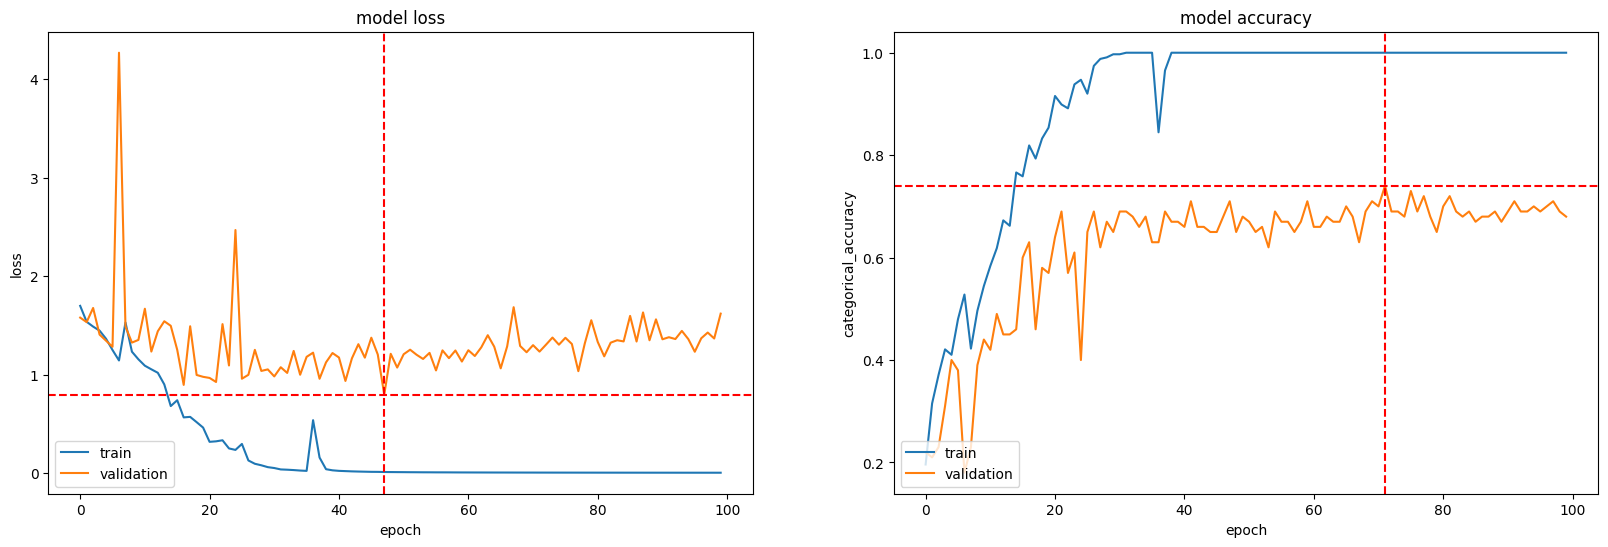

In [ ]:
plot_performance(history1)

In [ ]:
source = '/content/' + zip_folder
zipfolder = zip_folder[:-1] + '.zip'
!zip -r {zipfolder} {source}

  adding: content/model1_20240102_04_52_12/ (stored 0%)
  adding: content/model1_20240102_04_52_12/model-00033-0.03230-1.00000-1.01608-0.68000.h5 (deflated 12%)
  adding: content/model1_20240102_04_52_12/model-00070-0.00316-1.00000-1.22629-0.71000.h5 (deflated 13%)
  adding: content/model1_20240102_04_52_12/model-00074-0.00280-1.00000-1.37546-0.69000.h5 (deflated 13%)
  adding: content/model1_20240102_04_52_12/model-00023-0.33146-0.89140-1.51211-0.57000.h5 (deflated 13%)
  adding: content/model1_20240102_04_52_12/model-00024-0.24856-0.93816-1.09181-0.61000.h5 (deflated 13%)
  adding: content/model1_20240102_04_52_12/model-00042-0.01795-1.00000-0.93440-0.71000.h5 (deflated 14%)
  adding: content/model1_20240102_04_52_12/model-00063-0.00401-1.00000-1.27620-0.68000.h5 (deflated 13%)
  adding: content/model1_20240102_04_52_12/model-00003-1.48703-0.37104-1.67616-0.23000.h5 (deflated 25%)
  adding: content/model1_20240102_04_52_12/model-00081-0.00235-1.00000-1.33085-0.70000.h5 (deflated 13%)

##### Model 1 has overfitting issue and the accuracy is low

### Model 2

*Conv3D + BatchNormalisation + Dropout (to reduce the overfitting.)*

In [ ]:
model2 = Sequential()

model2.add(Conv3D(16, kernel_size=3, activation='relu', input_shape=input_shape))
model2.add(Conv3D(32, kernel_size=3, activation='relu'))
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))
model2.add(BatchNormalization())
model2.add(Dropout(0.2))
#
model2.add(Conv3D(64, kernel_size=3, activation='relu'))
model2.add(MaxPooling3D(pool_size=(1, 2, 2)))
model2.add(BatchNormalization())
model2.add(Dropout(0.2))
#
model2.add(Conv3D(128, kernel_size=(1, 3, 3), activation='relu'))
model2.add(MaxPooling3D(pool_size=(1, 2, 2)))
model2.add(BatchNormalization())
model2.add(Dropout(0.2))
#
model2.add(GlobalAveragePooling3D())
model2.add(Dense(256, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dense(5, activation='softmax'))

optimiser2 = tf.keras.optimizers.SGD()
model2.compile(optimizer=optimiser2, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model2.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 9, 118, 118, 16)   1312      
                                                                 
 conv3d_1 (Conv3D)           (None, 7, 116, 116, 32)   13856     
                                                                 
 max_pooling3d (MaxPooling3  (None, 3, 58, 58, 32)     0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 3, 58, 58, 32)     128       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 3, 58, 58, 32)     0         
                                                                 
 conv3d_2 (Conv3D)           (None, 1, 56, 56, 64)     5

In [ ]:
history2 = model2.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/gdrive/MyDrive/Gesture_Recognition/train ; batch size = 50
Epoch 1/100
14/14 [==============================] - ETA: 0s - loss: 1.5415 - categorical_accuracy: 0.4027  Source path =  /content/gdrive/MyDrive/Gesture_Recognition/val ; batch size = 50

Epoch 1: saving model to model_20240102_09_09_50/model-00001-1.54147-0.40271-1.62176-0.23000.h5
14/14 [==============================] - 2601s 199s/step - loss: 1.5415 - categorical_accuracy: 0.4027 - val_loss: 1.6218 - val_categorical_accuracy: 0.2300 - lr: 0.0100
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - ETA: 0s - loss: 1.2244 - categorical_accuracy: 0.5113
Epoch 2: saving model to model_20240102_09_09_50/model-00002-1.22440-0.51131-1.64256-0.18000.h5
14/14 [==============================] - 63s 5s/step - loss: 1.2244 - categorical_accuracy: 0.5113 - val_loss: 1.6426 - val_categorical_accuracy: 0.1800 - lr: 0.0100
Epoch 3/100
14/14 [==============================] - ETA: 0s - loss: 1.1004 - categorical_accuracy: 0.5626
Epoch 3: saving model to model_20240102_09_09_50/model-00003-1.10038-0.56259-1.61345-0.22000.h5
14/14 [==============================] - 62s 5s/step - loss: 1.1004 - categorical_accuracy: 0.5626 - val_loss: 1.6134 - val_categorical_accuracy: 0.2200 - lr: 0.0100
Epoch 4/100
14/14 [==============================] - ETA: 0s - loss: 0.9848 - categorical_accuracy: 0.6229
Epoch 4: saving model to model_20240102_09_09_50/model-00004-0.98481-0.62293-1.62923-0.23000.h5
14/14 [==============================] - 62s 5s/step - loss: 0.9848 - c

Minimum validation loss: 1.109 at EPOCH: 79
Maximum validation accuracy: 0.72 at EPOCH: 79


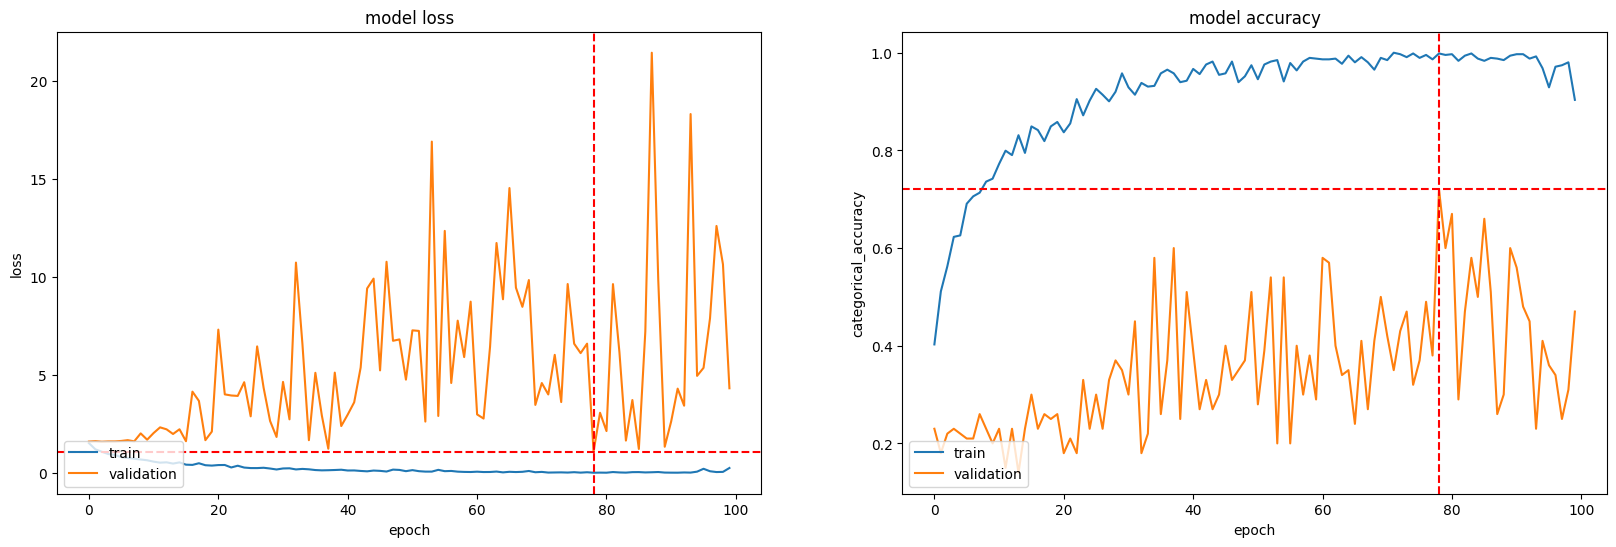

In [ ]:
plot_performance(history2)

In [ ]:
source = '/content/' + zip_folder
zipfolder = zip_folder[:-1] + '.zip'
!zip -r {zipfolder} {source}

  adding: content/model_20240102_09_09_50/ (stored 0%)
  adding: content/model_20240102_09_09_50/model-00002-1.22440-0.51131-1.64256-0.18000.h5 (deflated 12%)
  adding: content/model_20240102_09_09_50/model-00070-0.05664-0.98944-3.48844-0.50000.h5 (deflated 11%)
  adding: content/model_20240102_09_09_50/model-00030-0.19747-0.95777-1.85552-0.35000.h5 (deflated 11%)
  adding: content/model_20240102_09_09_50/model-00031-0.24944-0.92911-4.66261-0.30000.h5 (deflated 11%)
  adding: content/model_20240102_09_09_50/model-00040-0.18481-0.94268-2.41171-0.51000.h5 (deflated 11%)
  adding: content/model_20240102_09_09_50/model-00021-0.42254-0.83710-7.32844-0.18000.h5 (deflated 11%)
  adding: content/model_20240102_09_09_50/model-00098-0.06639-0.97436-12.61390-0.25000.h5 (deflated 11%)
  adding: content/model_20240102_09_09_50/model-00081-0.03377-0.99698-2.15550-0.67000.h5 (deflated 11%)
  adding: content/model_20240102_09_09_50/model-00084-0.03741-0.99849-1.67176-0.58000.h5 (deflated 11%)
  adding

##### Model 2 is highly overfit, as the accuracy vary at a large scale

### Model 3 *(Final Model)*:

*Conv2D + GRU*

In [ ]:
model3 = Sequential()

model3.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu'), input_shape=input_shape))
model3.add(TimeDistributed(MaxPooling2D(pool_size=2)))

model3.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu')))
model3.add(TimeDistributed(MaxPooling2D(pool_size=2)))

model3.add(TimeDistributed(GlobalAveragePooling2D()))
model3.add(TimeDistributed(Dense(128, activation='relu')))
model3.add(GRU(128))
model3.add(Dense(5, activation='softmax'))

oprimizer3 = optimizers.Adam()
model3.compile(optimizer=oprimizer3, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model3.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_6 (TimeDi  (None, 11, 118, 118, 32   896       
 stributed)                  )                                   
                                                                 
 time_distributed_7 (TimeDi  (None, 11, 59, 59, 32)    0         
 stributed)                                                      
                                                                 
 time_distributed_8 (TimeDi  (None, 11, 57, 57, 64)    18496     
 stributed)                                                      
                                                                 
 time_distributed_9 (TimeDi  (None, 11, 28, 28, 64)    0         
 stributed)                                                      
                                                                 
 time_distributed_10 (TimeD  (None, 11, 64)           

In [ ]:
history3 = model3.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/gdrive/MyDrive/Gesture_Recognition/train ; batch size = 50
Epoch 1/100
14/14 [==============================] - ETA: 0s - loss: 1.6120 - categorical_accuracy: 0.1885Source path =  /content/gdrive/MyDrive/Gesture_Recognition/val ; batch size = 50

Epoch 1: saving model to model_20240102_13_19_02/model-00001-1.61199-0.18854-1.60066-0.23000.h5
14/14 [==============================] - 73s 5s/step - loss: 1.6120 - categorical_accuracy: 0.1885 - val_loss: 1.6007 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/100
14/14 [==============================] - ETA: 0s - loss: 1.6092 - categorical_accuracy: 0.2006
Epoch 2: saving model to model_20240102_13_19_02/model-00002-1.60916-0.20060-1.58730-0.20000.h5
14/14 [==============================] - 61s 5s/step - loss: 1.6092 - categorical_accuracy: 0.2006 - val_loss: 1.5873 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/100
14/14 [==============================] - ETA: 0s - loss: 1.5950 - categorical_accuracy

Minimum validation loss: 0.436 at EPOCH: 92
Maximum validation accuracy: 0.8 at EPOCH: 92


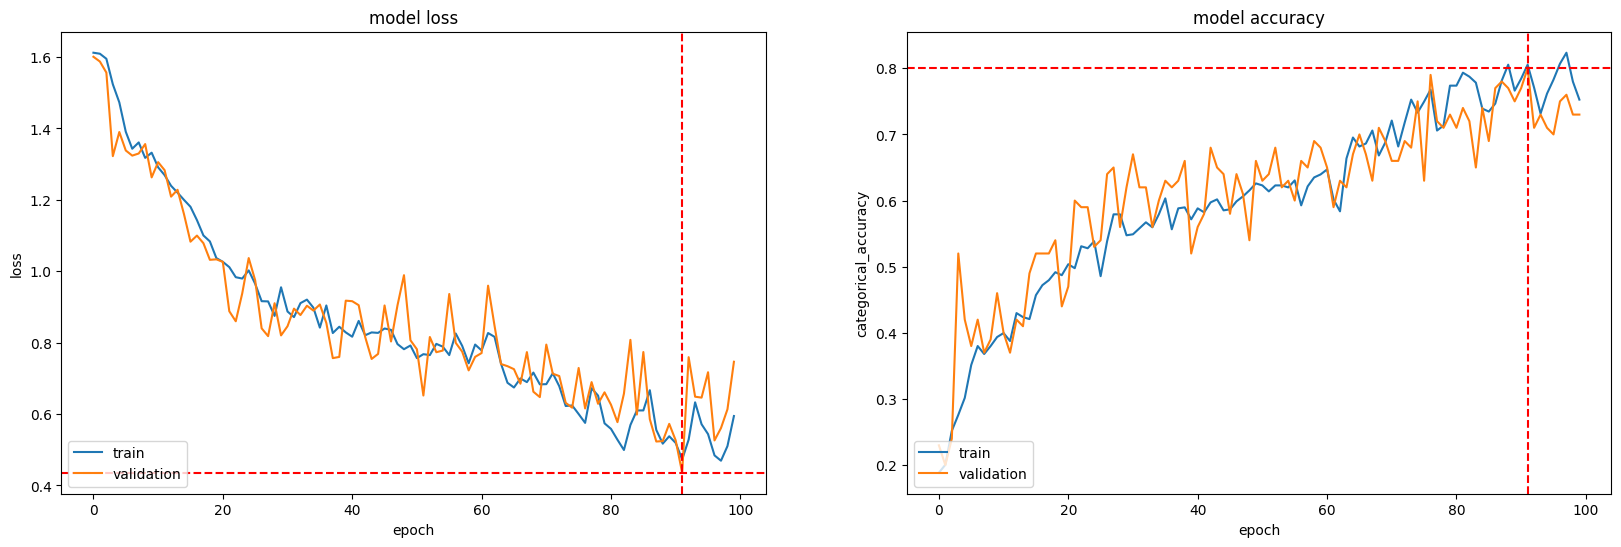

In [ ]:
plot_performance(history3)

The model converged to the minimum point at epoch 92 where the loss was minimum and the accuracy was around 80% in both Train and Validation dataset. This model can be considered as a better model than the other models

In [ ]:
source = '/content/' + zip_folder
zipfolder = zip_folder[:-1] + '.zip'
!zip -r {zipfolder} {source}

  adding: content/model_20240102_13_19_02/ (stored 0%)
  adding: content/model_20240102_13_19_02/model-00028-0.91549-0.57919-0.81815-0.65000.h5 (deflated 9%)
  adding: content/model_20240102_13_19_02/model-00036-0.84204-0.60332-0.90682-0.63000.h5 (deflated 9%)
  adding: content/model_20240102_13_19_02/model-00070-0.68315-0.68778-0.64744-0.69000.h5 (deflated 10%)
  adding: content/model_20240102_13_19_02/model-00090-0.53772-0.76621-0.57247-0.75000.h5 (deflated 11%)
  adding: content/model_20240102_13_19_02/model-00095-0.57143-0.76169-0.64599-0.71000.h5 (deflated 11%)
  adding: content/model_20240102_13_19_02/model-00024-0.97948-0.52790-0.93785-0.59000.h5 (deflated 10%)
  adding: content/model_20240102_13_19_02/model-00026-0.96477-0.48567-0.97466-0.54000.h5 (deflated 10%)
  adding: content/model_20240102_13_19_02/model-00006-1.39067-0.35143-1.33819-0.38000.h5 (deflated 12%)
  adding: content/model_20240102_13_19_02/model-00096-0.54380-0.78281-0.71713-0.70000.h5 (deflated 11%)
  adding: c

### Model 4:

*Conv2D + GRU + BatchNormalisation*

In [ ]:
model4 = Sequential()

model4.add(TimeDistributed(Conv2D(16, (3, 3), activation='relu'), input_shape=input_shape))
model4.add(TimeDistributed(MaxPooling2D(pool_size=2)))
model4.add(BatchNormalization())

model4.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu')))
model4.add(TimeDistributed(MaxPooling2D(pool_size=2)))
model4.add(BatchNormalization())

model4.add(TimeDistributed(GlobalAveragePooling2D()))
model4.add(BatchNormalization())

model4.add(TimeDistributed(Dense(64, activation='relu')))
model4.add(GRU(64))
model4.add(BatchNormalization())

model4.add(Dense(5, activation='softmax'))

oprimizer4 = optimizers.Adam()
model4.compile(optimizer=oprimizer4, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model4.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_24 (TimeD  (None, 11, 118, 118, 16   448       
 istributed)                 )                                   
                                                                 
 time_distributed_25 (TimeD  (None, 11, 59, 59, 16)    0         
 istributed)                                                     
                                                                 
 batch_normalization_12 (Ba  (None, 11, 59, 59, 16)    64        
 tchNormalization)                                               
                                                                 
 time_distributed_26 (TimeD  (None, 11, 57, 57, 32)    4640      
 istributed)                                                     
                                                                 
 time_distributed_27 (TimeD  (None, 11, 28, 28, 32)   

In [ ]:
history4 = model4.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/100
14/14 [==============================] - ETA: 0s - loss: 1.8112 - categorical_accuracy: 0.2881
Epoch 1: saving model to model_20240102_15_04_44/model-00001-1.81121-0.28808-1.60767-0.23000.h5
14/14 [==============================] - 75s 5s/step - loss: 1.8112 - categorical_accuracy: 0.2881 - val_loss: 1.6077 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/100
14/14 [==============================] - ETA: 0s - loss: 1.2429 - categorical_accuracy: 0.4902
Epoch 2: saving model to model_20240102_15_04_44/model-00002-1.24286-0.49020-1.60112-0.25000.h5
14/14 [==============================] - 61s 5s/step - loss: 1.2429 - categorical_accuracy: 0.4902 - val_loss: 1.6011 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 3/100
14/14 [==============================] - ETA: 0s - loss: 1.0263 - categorical_accuracy: 0.6003
Epoch 3: saving model to model_20240102_15_04_44/model-00003-1.02635-0.60030-1.61185-0.19000.h5
14/14 [==============================] - 60s 5s/step - loss

Minimum validation loss: 1.29 at EPOCH: 80
Maximum validation accuracy: 0.66 at EPOCH: 80


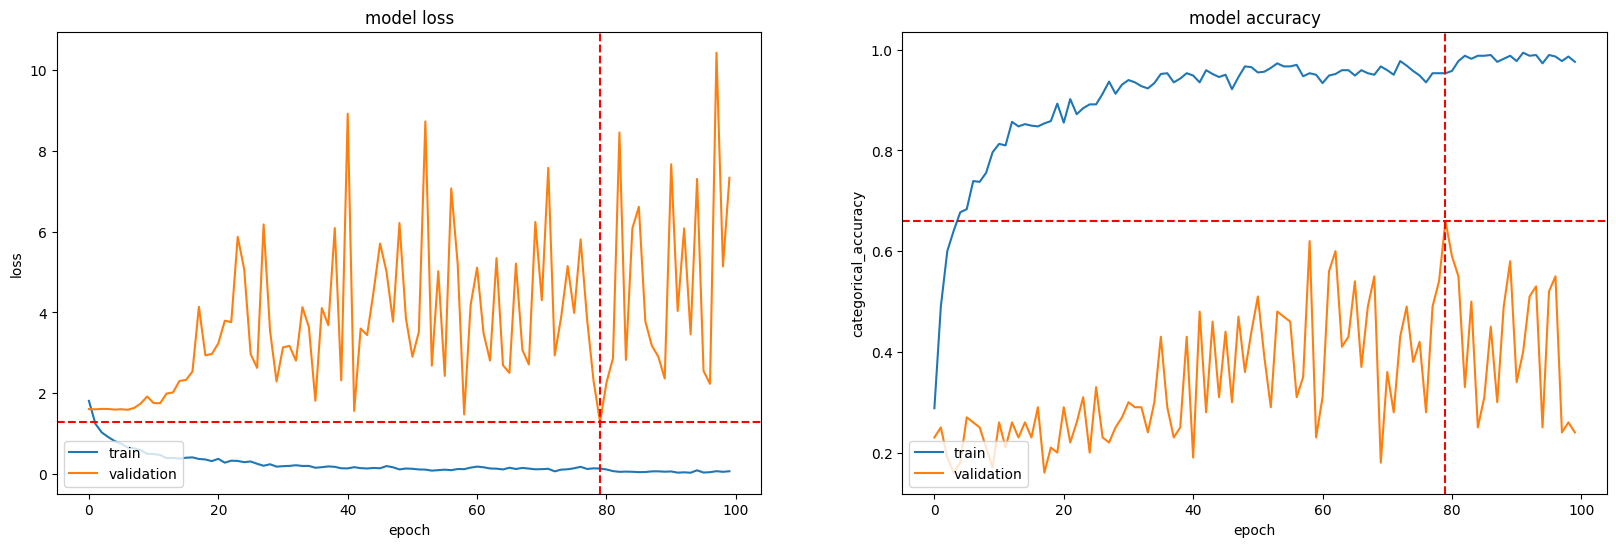

In [ ]:
plot_performance(history4)

In [ ]:
source = '/content/' + zip_folder
zipfolder = zip_folder[:-1] + '.zip'
!zip -r {zipfolder} {source}

  adding: content/model_20240102_15_04_44/ (stored 0%)
  adding: content/model_20240102_15_04_44/model-00013-0.39419-0.85671-1.99081-0.26000.h5 (deflated 23%)
  adding: content/model_20240102_15_04_44/model-00008-0.63769-0.73756-1.63630-0.25000.h5 (deflated 23%)
  adding: content/model_20240102_15_04_44/model-00020-0.31899-0.89291-2.97213-0.20000.h5 (deflated 23%)
  adding: content/model_20240102_15_04_44/model-00063-0.13656-0.95173-2.80961-0.60000.h5 (deflated 23%)
  adding: content/model_20240102_15_04_44/model-00076-0.14175-0.94872-3.98808-0.42000.h5 (deflated 22%)
  adding: content/model_20240102_15_04_44/model-00045-0.14978-0.94570-4.51969-0.31000.h5 (deflated 23%)
  adding: content/model_20240102_15_04_44/model-00093-0.04156-0.98793-6.08073-0.51000.h5 (deflated 23%)
  adding: content/model_20240102_15_04_44/model-00055-0.09452-0.96682-5.01928-0.47000.h5 (deflated 23%)
  adding: content/model_20240102_15_04_44/model-00084-0.05928-0.98190-2.82408-0.50000.h5 (deflated 23%)
  adding:

### Model 5:

*Conv2D + LSTM (1 Layer) + BatchNormalisation*

In [ ]:
model5 = Sequential()

model5.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu'), input_shape=input_shape))
model5.add(TimeDistributed(MaxPooling2D(pool_size=2)))
model5.add(BatchNormalization())

model5.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu')))
model5.add(TimeDistributed(MaxPooling2D(pool_size=2)))
model5.add(BatchNormalization())

model5.add(ConvLSTM2D(filters=64, kernel_size=(3, 3), activation='relu', return_sequences=False))
model5.add(BatchNormalization())

model5.add(TimeDistributed(Dense(128, activation='relu')))
model5.add(GlobalAveragePooling2D())
model5.add(BatchNormalization())

model5.add(Dense(128, activation='relu'))

model5.add(Dense(5, activation='softmax'))

In [ ]:
optimiser5 = tf.keras.optimizers.SGD()
model5.compile(optimizer=optimiser5, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model5.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_30 (TimeD  (None, 11, 118, 118, 32   896       
 istributed)                 )                                   
                                                                 
 time_distributed_31 (TimeD  (None, 11, 59, 59, 32)    0         
 istributed)                                                     
                                                                 
 batch_normalization_16 (Ba  (None, 11, 59, 59, 32)    128       
 tchNormalization)                                               
                                                                 
 time_distributed_32 (TimeD  (None, 11, 57, 57, 64)    18496     
 istributed)                                                     
                                                                 
 time_distributed_33 (TimeD  (None, 11, 28, 28, 64)   

In [ ]:
history5 = model5.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/gdrive/MyDrive/Gesture_Recognition/train ; batch size = 50
Epoch 1/100
14/14 [==============================] - ETA: 0s - loss: 1.5096 - categorical_accuracy: 0.3725Source path =  /content/gdrive/MyDrive/Gesture_Recognition/val ; batch size = 50

Epoch 1: saving model to model_20240102_16_46_36/model-00001-1.50957-0.37255-1.61164-0.19000.h5
14/14 [==============================] - 73s 5s/step - loss: 1.5096 - categorical_accuracy: 0.3725 - val_loss: 1.6116 - val_categorical_accuracy: 0.1900 - lr: 0.0100
Epoch 2/100
14/14 [==============================] - ETA: 0s - loss: 1.2002 - categorical_accuracy: 0.5309
Epoch 2: saving model to model_20240102_16_46_36/model-00002-1.20022-0.53092-1.61149-0.23000.h5
14/14 [==============================] - 61s 5s/step - loss: 1.2002 - categorical_accuracy: 0.5309 - val_loss: 1.6115 - val_categorical_accuracy: 0.2300 - lr: 0.0100
Epoch 3/100
14/14 [==============================] - ETA: 0s - loss: 1.0392 - categorical_accuracy

Minimum validation loss: 0.315 at EPOCH: 88
Maximum validation accuracy: 0.89 at EPOCH: 88


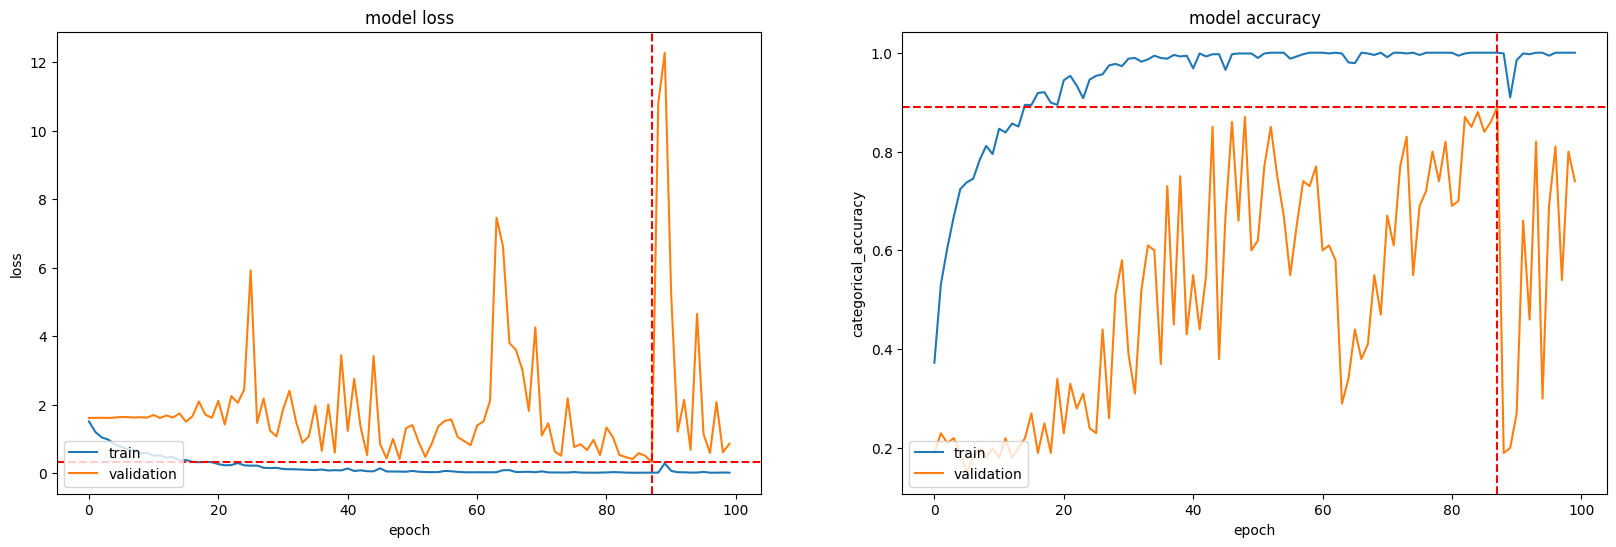

In [ ]:
plot_performance(history5)

In [ ]:
source = '/content/' + zip_folder
zipfolder = zip_folder[:-1] + '.zip'
!zip -r {zipfolder} {source}

  adding: content/model_20240102_16_46_36/ (stored 0%)
  adding: content/model_20240102_16_46_36/model-00083-0.02359-0.99849-0.52850-0.87000.h5 (deflated 9%)
  adding: content/model_20240102_16_46_36/model-00094-0.01435-1.00000-0.68079-0.82000.h5 (deflated 9%)
  adding: content/model_20240102_16_46_36/model-00049-0.04424-0.99849-0.41256-0.87000.h5 (deflated 9%)
  adding: content/model_20240102_16_46_36/model-00016-0.37929-0.89442-1.49964-0.27000.h5 (deflated 9%)
  adding: content/model_20240102_16_46_36/model-00068-0.03401-0.99849-3.01024-0.41000.h5 (deflated 9%)
  adding: content/model_20240102_16_46_36/model-00024-0.29616-0.90799-2.05165-0.31000.h5 (deflated 9%)
  adding: content/model_20240102_16_46_36/model-00087-0.01182-1.00000-0.50283-0.86000.h5 (deflated 9%)
  adding: content/model_20240102_16_46_36/model-00096-0.03508-0.99397-1.13827-0.69000.h5 (deflated 9%)
  adding: content/model_20240102_16_46_36/model-00061-0.02469-1.00000-1.39115-0.60000.h5 (deflated 9%)
  adding: content/

### Model 6:

*Conv2D + LSTM (2 Layers) + BacthNormalization (Reduced Parameters)*

In [ ]:
model6 = Sequential()

model6.add(TimeDistributed(Conv2D(8, (3,3), activation='relu'), input_shape=input_shape))
model6.add(BatchNormalization())

model6.add(TimeDistributed(Conv2D(16, (3,3), activation='relu')))
model6.add(BatchNormalization())

model6.add(ConvLSTM2D(8, kernel_size = 3, return_sequences=True))
model6.add(BatchNormalization())

model6.add(ConvLSTM2D(8, kernel_size = 3, return_sequences=False))
model6.add(BatchNormalization())

model6.add(TimeDistributed(Dense(64, activation='relu')))
model6.add(BatchNormalization())

model6.add(GlobalAveragePooling2D())
model6.add(Dense(64, activation='relu'))

model6.add(Dense(5, activation='softmax'))

In [ ]:
optimiser6 = tf.keras.optimizers.Adam(learning_rate=0.001)
model6.compile(optimizer=optimiser6, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model6.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 11, 118, 118, 8)   224       
 ributed)                                                        
                                                                 
 batch_normalization (Batch  (None, 11, 118, 118, 8)   32        
 Normalization)                                                  
                                                                 
 time_distributed_1 (TimeDi  (None, 11, 116, 116, 16   1168      
 stributed)                  )                                   
                                                                 
 batch_normalization_1 (Bat  (None, 11, 116, 116, 16   64        
 chNormalization)            )                                   
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 11, 114, 114, 8)   6

In [ ]:
history6 = model6.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/gdrive/MyDrive/Gesture_Recognition/train ; batch size = 50
Epoch 1/100
14/14 [==============================] - ETA: 0s - loss: 1.5327 - categorical_accuracy: 0.2805  Source path =  /content/gdrive/MyDrive/Gesture_Recognition/val ; batch size = 50

Epoch 1: saving model to model_20231225_05_27_47/model-00001-1.53269-0.28054-1.61325-0.23000.h5
14/14 [==============================] - 2180s 166s/step - loss: 1.5327 - categorical_accuracy: 0.2805 - val_loss: 1.6132 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - ETA: 0s - loss: 1.3591 - categorical_accuracy: 0.4570
Epoch 2: saving model to model_20231225_05_27_47/model-00002-1.35906-0.45701-1.63490-0.18000.h5
14/14 [==============================] - 67s 5s/step - loss: 1.3591 - categorical_accuracy: 0.4570 - val_loss: 1.6349 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 3/100
14/14 [==============================] - ETA: 0s - loss: 1.2335 - categorical_accuracy: 0.5309
Epoch 3: saving model to model_20231225_05_27_47/model-00003-1.23349-0.53092-1.60137-0.19000.h5
14/14 [==============================] - 66s 5s/step - loss: 1.2335 - categorical_accuracy: 0.5309 - val_loss: 1.6014 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 4/100
14/14 [==============================] - ETA: 0s - loss: 1.1271 - categorical_accuracy: 0.5430
Epoch 4: saving model to model_20231225_05_27_47/model-00004-1.12710-0.54299-1.58965-0.22000.h5
14/14 [==============================] - 66s 5s/step - loss: 1.1271 - c

Minimum validation loss: 0.616 at EPOCH: 98
Maximum validation accuracy: 0.84 at EPOCH: 50


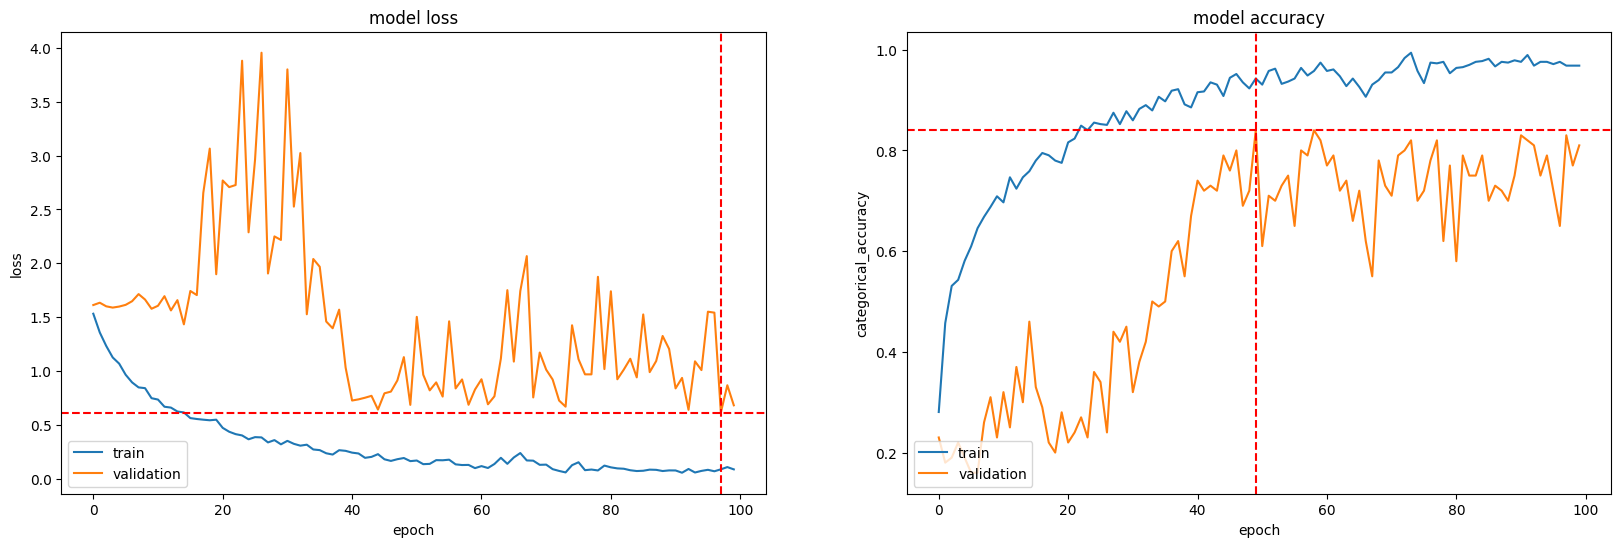

In [ ]:
plot_performance(history6)

In [ ]:
source = '/content/' + zip_folder
zipfolder = zip_folder[:-1] + '.zip'
!zip -r {zipfolder} {source}

  adding: content/model_20231225_05_27_47/ (stored 0%)
  adding: content/model_20231225_05_27_47/model-00100-0.08886-0.96833-0.68328-0.81000.h5 (deflated 35%)
  adding: content/model_20231225_05_27_47/model-00036-0.26740-0.89744-1.96828-0.50000.h5 (deflated 35%)
  adding: content/model_20231225_05_27_47/model-00059-0.13027-0.95777-0.68808-0.84000.h5 (deflated 35%)
  adding: content/model_20231225_05_27_47/model-00067-0.24033-0.90649-1.74327-0.62000.h5 (deflated 35%)
  adding: content/model_20231225_05_27_47/model-00081-0.10769-0.96380-1.74086-0.58000.h5 (deflated 35%)
  adding: content/model_20231225_05_27_47/model-00098-0.08939-0.96833-0.61639-0.83000.h5 (deflated 35%)
  adding: content/model_20231225_05_27_47/model-00082-0.09803-0.96531-0.92467-0.79000.h5 (deflated 35%)
  adding: content/model_20231225_05_27_47/model-00013-0.66196-0.72398-1.56335-0.37000.h5 (deflated 35%)
  adding: content/model_20231225_05_27_47/model-00093-0.09258-0.96833-0.64168-0.81000.h5 (deflated 35%)
  adding:

### Model 7:

*Conv2D + LSTM + Batch Normalization (Increased Layers)*

In [ ]:
model7 = Sequential()

model7.add(TimeDistributed(Conv2D(8, (3,3), activation='relu'), input_shape=input_shape))
model7.add(TimeDistributed(MaxPooling2D(pool_size=2)))
model7.add(BatchNormalization())

model7.add(TimeDistributed(Conv2D(16, (3,3), activation='relu')))
model7.add(TimeDistributed(MaxPooling2D(pool_size=2)))
model7.add(BatchNormalization())

model7.add(TimeDistributed(Conv2D(32, (3,3), activation='relu')))
model7.add(TimeDistributed(MaxPooling2D(pool_size=2)))
model7.add(BatchNormalization())

model7.add(TimeDistributed(Conv2D(64, (3,3), activation='relu')))
model7.add(TimeDistributed(MaxPooling2D(pool_size=2)))
model7.add(BatchNormalization())

model7.add(ConvLSTM2D(8, kernel_size=3, return_sequences=True))
model7.add(ConvLSTM2D(16, kernel_size=3, return_sequences=False))
model7.add(GlobalAveragePooling2D())
model7.add(BatchNormalization())

model7.add(Dense(16, activation='relu'))
model7.add(Dense(5, activation='softmax'))

optimizer7 = tf.keras.optimizers.Adam()
model7.compile(optimizer=optimizer7, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model7.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_35 (TimeD  (None, 11, 118, 118, 8)   224       
 istributed)                                                     
                                                                 
 time_distributed_36 (TimeD  (None, 11, 59, 59, 8)     0         
 istributed)                                                     
                                                                 
 batch_normalization_20 (Ba  (None, 11, 59, 59, 8)     32        
 tchNormalization)                                               
                                                                 
 time_distributed_37 (TimeD  (None, 11, 57, 57, 16)    1168      
 istributed)                                                     
                                                                 
 time_distributed_38 (TimeD  (None, 11, 28, 28, 16)   

In [ ]:
history7 = model7.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/gdrive/MyDrive/Gesture_Recognition/train ; batch size = 50
Epoch 1/100
14/14 [==============================] - ETA: 0s - loss: 1.5116 - categorical_accuracy: 0.3183Source path =  /content/gdrive/MyDrive/Gesture_Recognition/val ; batch size = 50

Epoch 1: saving model to model_20240102_19_00_53/model-00001-1.51158-0.31825-1.59381-0.26000.h5
14/14 [==============================] - 77s 5s/step - loss: 1.5116 - categorical_accuracy: 0.3183 - val_loss: 1.5938 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 2/100
14/14 [==============================] - ETA: 0s - loss: 1.2015 - categorical_accuracy: 0.5309
Epoch 2: saving model to model_20240102_19_00_53/model-00002-1.20151-0.53092-1.59446-0.32000.h5
14/14 [==============================] - 61s 5s/step - loss: 1.2015 - categorical_accuracy: 0.5309 - val_loss: 1.5945 - val_categorical_accuracy: 0.3200 - lr: 0.0010
Epoch 3/100
14/14 [==============================] - ETA: 0s - loss: 1.0254 - categorical_accuracy

Minimum validation loss: 0.97 at EPOCH: 34
Maximum validation accuracy: 0.76 at EPOCH: 68


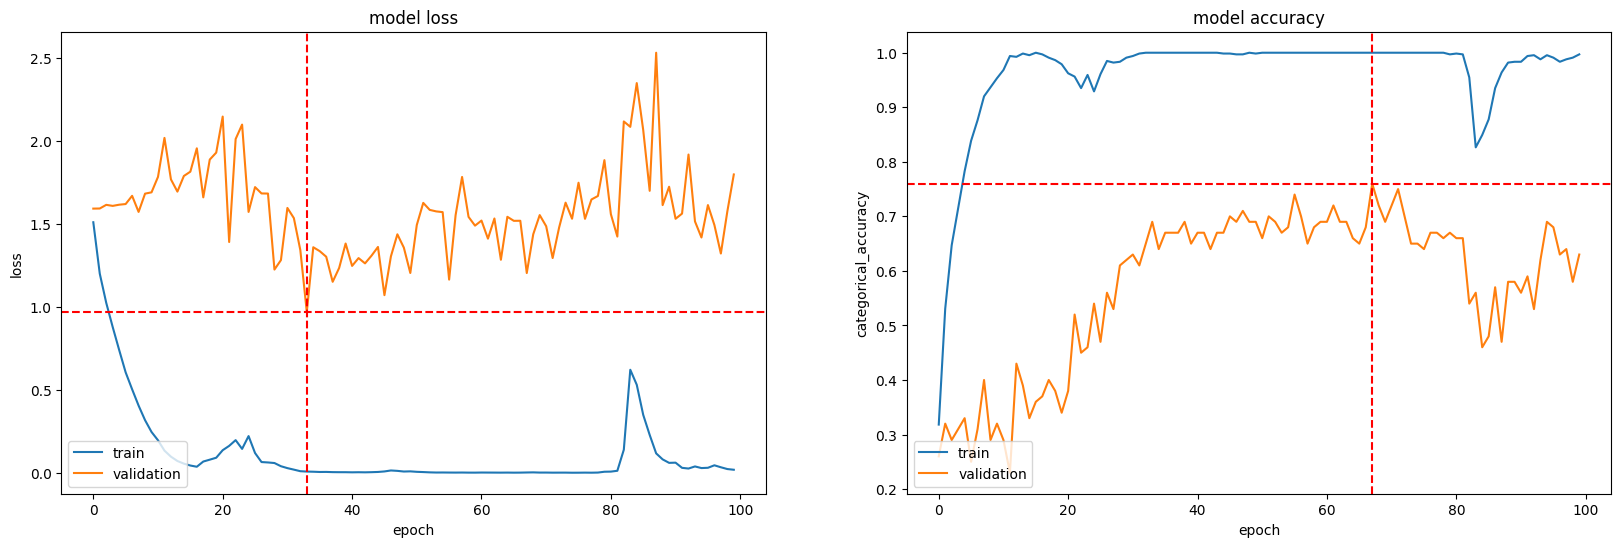

In [ ]:
plot_performance(history7)

In [ ]:
source = '/content/' + zip_folder
zipfolder = zip_folder[:-1] + '.zip'
!zip -r {zipfolder} {source}

  adding: content/model_20240102_19_00_53/ (stored 0%)
  adding: content/model_20240102_19_00_53/model-00004-0.87943-0.71493-1.61023-0.31000.h5 (deflated 27%)
  adding: content/model_20240102_19_00_53/model-00070-0.00196-1.00000-1.55470-0.69000.h5 (deflated 27%)
  adding: content/model_20240102_19_00_53/model-00040-0.00421-1.00000-1.38323-0.65000.h5 (deflated 27%)
  adding: content/model_20240102_19_00_53/model-00082-0.01281-0.99698-1.42529-0.66000.h5 (deflated 27%)
  adding: content/model_20240102_19_00_53/model-00031-0.02879-0.99397-1.59781-0.63000.h5 (deflated 27%)
  adding: content/model_20240102_19_00_53/model-00071-0.00204-1.00000-1.48758-0.72000.h5 (deflated 27%)
  adding: content/model_20240102_19_00_53/model-00034-0.00807-1.00000-0.97029-0.69000.h5 (deflated 27%)
  adding: content/model_20240102_19_00_53/model-00007-0.50424-0.87632-1.67088-0.31000.h5 (deflated 27%)
  adding: content/model_20240102_19_00_53/model-00077-0.00167-1.00000-1.53209-0.67000.h5 (deflated 27%)
  adding:

### Model 8:

*Conv2D + LSTM + Batch Normalization (Minimal/Decreased Filters)*

In [ ]:
model8 = Sequential()

model8.add(TimeDistributed(Conv2D(8, kernel_size=3), input_shape=input_shape))
model8.add(BatchNormalization())
model8.add(TimeDistributed(MaxPooling2D(pool_size=2)))

model8.add(TimeDistributed(Conv2D(8, kernel_size=3)))
model8.add(BatchNormalization())
model8.add(TimeDistributed(MaxPooling2D(pool_size=2)))

model8.add(TimeDistributed(Conv2D(16, kernel_size=3)))
model8.add(BatchNormalization())
model8.add(TimeDistributed(MaxPooling2D(pool_size=2)))

model8.add(ConvLSTM2D(8, kernel_size=3, return_sequences=True))
model8.add(ConvLSTM2D(8, kernel_size=3, return_sequences=False))

model8.add(GlobalAveragePooling2D())
model8.add(Dense(16, activation='relu'))

model8.add(Dense(5, activation='softmax'))

In [ ]:
optimizer8 = tf.keras.optimizers.Adam()
model8.compile(optimizer=optimizer8, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model8.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_12 (TimeD  (None, 11, 118, 118, 8)   224       
 istributed)                                                     
                                                                 
 batch_normalization_6 (Bat  (None, 11, 118, 118, 8)   32        
 chNormalization)                                                
                                                                 
 time_distributed_13 (TimeD  (None, 11, 59, 59, 8)     0         
 istributed)                                                     
                                                                 
 time_distributed_14 (TimeD  (None, 11, 57, 57, 8)     584       
 istributed)                                                     
                                                                 
 batch_normalization_7 (Bat  (None, 11, 57, 57, 8)    

In [ ]:
history8 = model8.fit(train_generator, verbose=1, epochs=num_epochs, validation_data=val_generator, steps_per_epoch=steps_per_epoch,
                    callbacks=callbacks_list, class_weight=None, validation_steps=validation_steps)

Epoch 1/100
14/14 [==============================] - ETA: 0s - loss: 1.5996 - categorical_accuracy: 0.2323  Source path =  /content/gdrive/MyDrive/Gesture_Recognition/val ; batch size = 50

Epoch 1: saving model to model_20231230_14_32_10/model-00001-1.59959-0.23228-1.60697-0.23000.h5
14/14 [==============================] - 2326s 178s/step - loss: 1.5996 - categorical_accuracy: 0.2323 - val_loss: 1.6070 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - ETA: 0s - loss: 1.5668 - categorical_accuracy: 0.2896
Epoch 2: saving model to model_20231230_14_32_10/model-00002-1.56678-0.28959-1.61353-0.20000.h5
14/14 [==============================] - 66s 5s/step - loss: 1.5668 - categorical_accuracy: 0.2896 - val_loss: 1.6135 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/100
14/14 [==============================] - ETA: 0s - loss: 1.5430 - categorical_accuracy: 0.3213
Epoch 3: saving model to model_20231230_14_32_10/model-00003-1.54303-0.32127-1.60252-0.24000.h5
14/14 [==============================] - 63s 5s/step - loss: 1.5430 - categorical_accuracy: 0.3213 - val_loss: 1.6025 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 4/100
14/14 [==============================] - ETA: 0s - loss: 1.4969 - categorical_accuracy: 0.3906
Epoch 4: saving model to model_20231230_14_32_10/model-00004-1.49690-0.39065-1.60518-0.21000.h5
14/14 [==============================] - 63s 5s/step - loss: 1.4969 - c

Minimum validation loss: 0.565 at EPOCH: 94
Maximum validation accuracy: 0.82 at EPOCH: 94


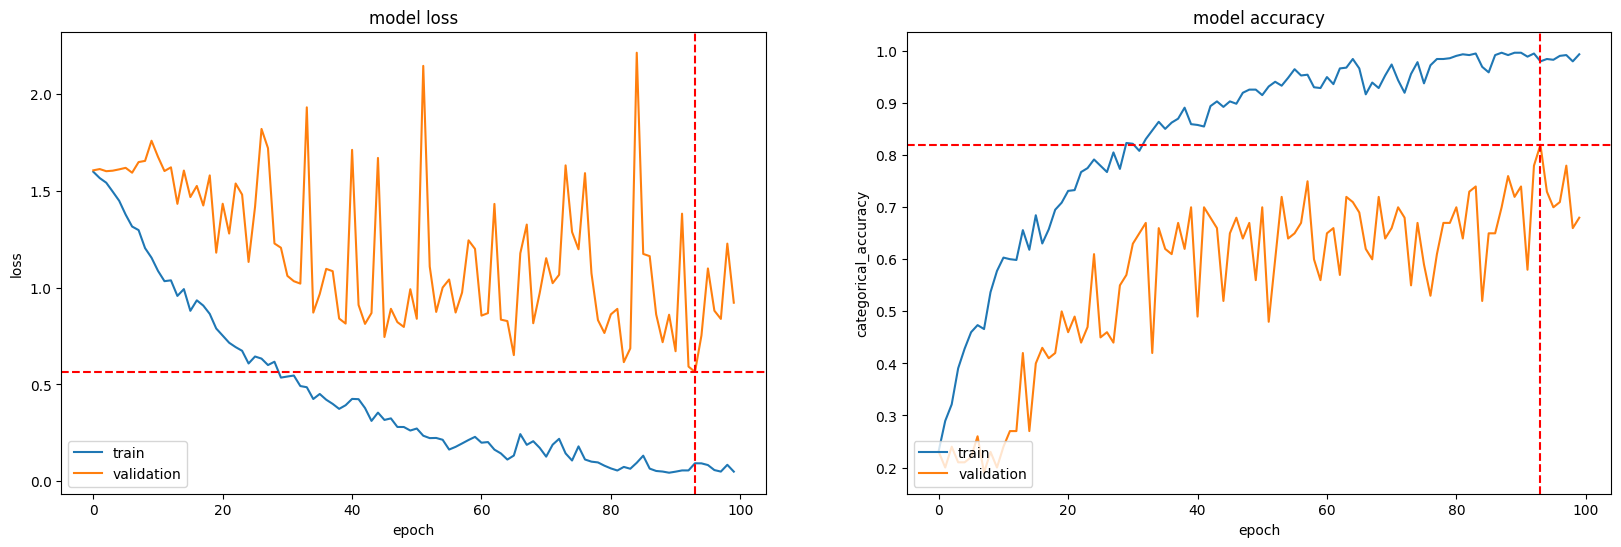

In [ ]:
plot_performance(history8)

In [ ]:
source = '/content/' + zip_folder
zipfolder = zip_folder[:-1] + '.zip'
!zip -r {zipfolder} {source}

  adding: content/model_20231230_14_32_10/ (stored 0%)
  adding: content/model_20231230_14_32_10/model-00090-0.04397-0.99698-0.86072-0.72000.h5 (deflated 38%)
  adding: content/model_20231230_14_32_10/model-00072-0.18888-0.94419-1.02379-0.70000.h5 (deflated 38%)
  adding: content/model_20231230_14_32_10/model-00004-1.49690-0.39065-1.60518-0.21000.h5 (deflated 37%)
  adding: content/model_20231230_14_32_10/model-00039-0.37400-0.89140-0.84084-0.62000.h5 (deflated 38%)
  adding: content/model_20231230_14_32_10/model-00061-0.19918-0.95023-0.85599-0.65000.h5 (deflated 38%)
  adding: content/model_20231230_14_32_10/model-00063-0.16335-0.96682-1.43339-0.57000.h5 (deflated 38%)
  adding: content/model_20231230_14_32_10/model-00042-0.42419-0.85520-0.91129-0.70000.h5 (deflated 38%)
  adding: content/model_20231230_14_32_10/model-00015-0.99306-0.61840-1.60589-0.27000.h5 (deflated 37%)
  adding: content/model_20231230_14_32_10/model-00071-0.12708-0.97436-1.15288-0.66000.h5 (deflated 38%)
  adding: